In [1]:
import numpy as np
import gym
from gym import spaces

from common.harvester_fns import csv_solar_harvester
from common.requester_fns import request_gen
from common.env_utils import battery, tx_prob

from collections import deque

In [2]:
def tx_rewardfn(x,k=-0.4):
    x = (x-0.1)/0.9
    y = (x-k*x)/(k-2*k*np.abs(x)+1)
    kreward = y*0.9 +0.1
    return kreward

(0, 1)

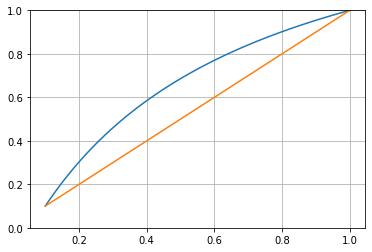

In [3]:
import matplotlib.pyplot as plt
conformity = np.linspace(0.1,1,100)
tx_reward = tx_rewardfn(conformity)
plt.plot(conformity, tx_reward)
plt.plot(conformity, conformity)

plt.grid()
plt.ylim([0,1])

In [4]:
class sensetx(gym.Env):    
    def __init__(self):
        super(sensetx, self).__init__()
        
        # Actions = energy_consumed
        self.action_space = spaces.Box(low=0,
                                       high=1,
                                       shape=(2,))

        # Observation = [time, h_energy, p_energy, b_energy, m_energy, req1, req2]
        self.observation_space = spaces.Box(low=0, 
                                            high=1, 
                                            shape=(7,))
########################################################
#     def set_pref(self,preference):
#         self.preference = preference
########################################################

    def set_env(self,location, year, timeslots_per_day, req_type, offset, p_horizon, hmean=None):
        self.location = location
        self.year = year
        self.REQ_TIMESLOTS_PER_DAY=timeslots_per_day
        self.HFACTOR = 5*1E-3*240/self.REQ_TIMESLOTS_PER_DAY
        self.DFACTOR = 5*1E-3*240/self.REQ_TIMESLOTS_PER_DAY
        self.rq_type = req_type
        self.offset = int(offset) # offset for request generator [when using random_day]
        self.MIN_BATT = 0.1
        self.MIN_DC = 0.1
        self.p_horizon = p_horizon # prediction horizons
        self.hmean = hmean # mean henergy if given
########################################################

    def reset(self):
        # Characterize the harvester
        self.READINGS_PER_DAY = 24       

        self.env_harvester = csv_solar_harvester(location=self.location,
                                                 year=self.year,
                                                 READINGS_PER_DAY = self.READINGS_PER_DAY,
                                                 SMAX=4.0, # Max GSR
                                                 HENERGY_NOISE=0.0, # henergy artifical noise
                                                 NORMALIZED_HMIN_THRES=1E-5, # henergy cutoff
                                                 REQ_TIMESLOTS_PER_DAY=self.REQ_TIMESLOTS_PER_DAY, # no. of timeslots per day
                                                 PREDICTION_HORIZON=self.p_horizon, # lookahead horizon to predict energy
                                                 PREDICTION_NOISE=0.0) # preidction noise
        self.env_timeslot_values = self.env_harvester.time_slots
        self.ENV_LIFETIME = self.env_harvester.no_of_days
        
        # Characterize the battery
        self.BINIT = 0.7
        self.BEFF  = 1.0
        self.env_battery = battery(self.BINIT,self.BEFF)

        # Characterize request generator
        hstream = np.array(self.env_harvester.henergy_stream)
        if self.hmean is None:
            self.hmean = hstream.mean()
        self.req_stream =  request_gen("random_day",
                                       htrace=hstream,
                                       hmean=self.hmean,
                                       mindc=self.MIN_DC,
                                       timesteps_per_day=self.REQ_TIMESLOTS_PER_DAY,
                                       offset=self.offset)
        self.req_stream2 =  request_gen("random",
                                       htrace=hstream,
                                       hmean=self.hmean,
                                       mindc=self.MIN_DC,
                                       timesteps_per_day=self.REQ_TIMESLOTS_PER_DAY,
                                       offset=self.offset)
       
        # Data logging variables
        self.env_log = [] # record all values in the environment
        self.action_log = [] # record all actions sent to the environment
        self.eno_log = []
        self.sense_dc_log = []
        self.tx_dc_log = []

        self.batt_slice = deque(maxlen=self.REQ_TIMESLOTS_PER_DAY*10)
        self.sense_reward_log = []
        self.tx_reward_log = []
        self.enp_reward_log = []

        # Observation variables
        self.time_obs = None
        self.henergy_obs = None
        self.penergy_obs = None
        self.benergy_obs = None
        self.menergy_obs = None
        self.req_obs = None
        self.req_obs2 = None

        
        # Environment Flags
        self.RECOVERY_MODE = False # battery is recovering to BINIT from complete discharge & node is suspended
        
        # Get observation
        self.time_obs, self.henergy_obs, self.penergy_obs, DAY_END, HARVESTER_END = self.env_harvester.step()
        self.benergy_obs = self.env_battery.get_batt_state()
        self.eno_log.append(self.benergy_obs)
        self.batt_slice.append(self.benergy_obs)
        self.menergy_obs = np.mean(self.batt_slice) # mean battery for given prediction horizon
        self.req_obs = self.req_stream[int(self.env_harvester.global_time)]
        self.req_obs2 = self.req_stream2[int(self.env_harvester.global_time)]

        self.obs = (self.time_obs/self.READINGS_PER_DAY,
                    self.henergy_obs,
                    self.penergy_obs,
                    self.benergy_obs,
                    self.menergy_obs,
                    self.req_obs,
                    self.req_obs2)
        log_data = self.obs
        self.env_log.append(log_data)
        return np.array(self.obs)
########################################################

    def action2dc(self,action):
        if action[0] < 0:
            sense_dc = 0
        else:
            sense_dc = max(self.MIN_DC, action[0]*self.req_obs)
        if action[1] < 0:
            tx_dc = 0
        else:
            tx_dc    = max(self.MIN_DC, action[1]*self.req_obs2)

        return sense_dc , tx_dc   
########################################################

    def step(self, action):
        # if the node is in recovery mode at any time during step(), 
        # this flag is set
        recovery_flag = self.RECOVERY_MODE

        # Execute Action
        if self.RECOVERY_MODE: # Is node already in recovery mode?
            self.recovery_action()
            recovery_flag = True
        else:
            ACTION_VALID = self.verify_action(action)
            if ACTION_VALID:
                self.execute_action(action)
            else:
                self.recovery_action()
                recovery_flag = True

        # Get next observation
        next_obs, done = self.next_obs() # this might change self.RECOVERY_MODE
        
        # Did the node enter recovery mode after executing action even though the action was valid?
        recovery_flag = recovery_flag or self.RECOVERY_MODE
        
        # Get reward
        # If the action was valid but resulted in entering recovery mode, then
        # reward should not be given by the action but rather by recovery mode.
        if recovery_flag: 
            reward = self.reward(action=(-1,-1))
        else:
            reward = self.reward(action)
        info = {}
        
        return np.array(next_obs), reward, done, info
########################################################

    def verify_action(self, action): # check if actions are valid
        assert self.RECOVERY_MODE == False, "Action does not need to be verified in recovery mode"
        sense_dc, tx_dc = self.action2dc(action)
        
        surplus_energy = (self.henergy_obs*self.HFACTOR - (sense_dc)*self.DFACTOR/2 - (tx_dc)*self.DFACTOR/2)
        if (-surplus_energy) < self.benergy_obs: # if there is sufficient energy in the battery to extract
            return True # valid action
        else:
            self.RECOVERY_MODE = True # switch to recovery mode
            return False # invalid action
########################################################

    def recovery_action(self):
        assert self.RECOVERY_MODE == True, "Node is not in recovery mode"
#         charge_qty =self.henergy_obs*self.HFACTOR
        charge_qty = self.BINIT/2
        self.env_battery.charge(charge_qty)
        self.batt_slice.clear()
        self.eno_log.append(charge_qty)
        self.action_log.append((-1,-1))
        self.sense_dc_log.append(0)
        self.tx_dc_log.append(0)

########################################################

    def execute_action(self, action): 
        assert self.RECOVERY_MODE==False, "Node is in recovery mode. Cannot execute action"

        sense_dc, tx_dc = self.action2dc(action)
        surplus_energy = (self.henergy_obs*self.HFACTOR - (sense_dc)*self.DFACTOR/2 - (tx_dc)*self.DFACTOR/2)
        
        if surplus_energy >= 0:
            self.env_battery.charge(surplus_energy)
        else:
            self.env_battery.discharge(surplus_energy)
        
        self.eno_log.append(surplus_energy)
        self.action_log.append(action)      
        self.sense_dc_log.append(sense_dc)
        self.tx_dc_log.append(tx_dc)
########################################################

    def next_obs(self): # update all observations

        self.time_obs, self.henergy_obs, self.penergy_obs, DAY_END, HARVESTER_END = self.env_harvester.step()

        if not HARVESTER_END:
            self.req_obs  = self.req_stream[int(self.env_harvester.global_time)]
            self.req_obs2 = self.req_stream2[int(self.env_harvester.global_time)]

            self.benergy_obs = self.env_battery.get_batt_state() # updated battery observation
            self.batt_slice.append(self.benergy_obs)
            self.menergy_obs = np.mean(self.batt_slice)
            
            if self.benergy_obs < self.MIN_BATT: # Is battery less than a threshold?
                self.RECOVERY_MODE = True
            
            if self.RECOVERY_MODE:
                if self.benergy_obs > self.BINIT: 
                    self.RECOVERY_MODE = False # snap out of recovery mode
                else:
                    self.RECOVERY_MODE = True # remain in recovery mode
            
        self.obs = (self.time_obs/self.READINGS_PER_DAY,
                    self.henergy_obs,
                    self.penergy_obs,
                    self.benergy_obs,
                    self.menergy_obs,
                    self.req_obs,
                    self.req_obs2)
        
        done = HARVESTER_END
        
        # don't log the values of the last next_state when harvester ends
        # this causes mismatch in array sizes with action_log/reward_rec etc.
        if not done: 
            log_data = self.obs
            self.env_log.append(log_data)

        return self.obs, done
########################################################
    def reward(self,action): # reward based on utility
        if action[0] < 0 and action[1] < 0: # if recovery mode
            sense_reward = 0   
            tx_reward = 0            
            enp_reward = 0
            reward = 0
            
        else:
            sense_dc, tx_dc = self.action2dc(action)
            sense_reward = min(1.0,sense_dc/self.req_obs)
            
            tx_reward = tx_rewardfn(min(1.0,tx_dc/self.req_obs2))
            
            batt_threshold = 0.8
            if self.menergy_obs > batt_threshold:
                enp_reward = 1
            else:
                enp_reward = (self.menergy_obs - self.MIN_BATT)/(batt_threshold-self.MIN_BATT)
        
        self.sense_reward_log.append(sense_reward)
        self.tx_reward_log.append(tx_reward)
        self.enp_reward_log.append(enp_reward)
        return (sense_reward, tx_reward, enp_reward)
########################################################
# End of sensetx()
########################################################

In [5]:
env = sensetx()

In [6]:
env_location = 'tokyo'
year = 1995 
timeslots_per_day = 24
REQ_TYPE = "dummy"
prediction_horizon = 10*timeslots_per_day
henergy_mean= 0.13904705134356052 # 10yr hmean for tokyo

env.set_env(env_location, year, timeslots_per_day, 
                REQ_TYPE, offset=timeslots_per_day/2,
                p_horizon=prediction_horizon,
                hmean=henergy_mean)


In [7]:
# action = (0.99, 0.99)
state = env.reset()

In [ ]:
print("step".ljust(5), "state".ljust(7), "act[0]".ljust(7), "act[1]".ljust(7), "s_rwd".ljust(7), "tx_rwd".ljust(8), "e_rwd".ljust(6), " nxt_state".ljust(12), "done".ljust(8))
counter = 0
for i in range(24*50):
    action = np.random.normal(loc=0.7, scale=0.3, size=(2,))
    action = tuple(np.clip(action,0,1))
    next_state, reward, done, _ = env.step(action)
    ep_done = done or env.RECOVERY_MODE or (counter==prediction_horizon-1)
    print(f'{i:4d}',end='')
    print(f'{state[3]:7.3f}',end='')
    print(f'{action[0]:8.3f}',end='')
    print(f'{action[1]:8.3f}',end='')
    print(f'{reward[0]:8.3f}',end='')
    print(f'{reward[1]:8.3f}',end='')
    print(f'{reward[2]:9.3f}',end='')
    print(f'{next_state[3]:12.3f}',end='  ')
    print(ep_done,end='\n')
    state = next_state
    counter += 1
    if ep_done:
        counter = 0      

In [9]:
iteration_result={}

# Saving traces
iteration_result['action_log'] = np.array(env.action_log)
iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
iteration_result['tx_dc_log'] = np.array(env.tx_dc_log)
iteration_result['env_log'] = np.array(env.env_log)
iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
iteration_result['tx_reward_log'] = np.array(env.tx_reward_log)
iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)


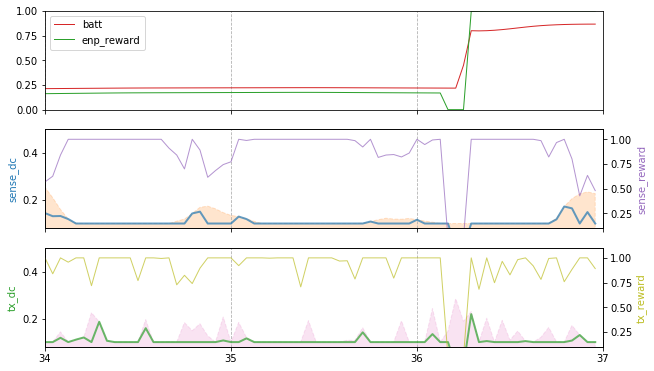

In [61]:
run_log = iteration_result 

START_DAY=34
NO_OF_DAYS_TO_PLOT = 3

# Get Environment Log
################################################################    

sense_dc_log = run_log['sense_dc_log']
tx_dc_log = run_log['tx_dc_log']

env_log = run_log['env_log']
henergy_obs_rec=env_log[:,1]
penergy_obs_rec=env_log[:,2]
benergy_obs_rec=env_log[:,3]
menergy_obs_rec=env_log[:,4]
req_obs_rec=env_log[:,5]
req_obs2_rec=env_log[:,6]

sense_reward_log = run_log['sense_reward_log']
tx_reward_log = run_log['tx_reward_log']
enp_reward_log = run_log['enp_reward_log']


NO_OF_TIMESLOTS_PER_DAY = timeslots_per_day
NO_OF_DATA_DAYS = int(len(henergy_obs_rec)/NO_OF_TIMESLOTS_PER_DAY)

END_DAY = min(START_DAY + NO_OF_DAYS_TO_PLOT, NO_OF_DATA_DAYS)

start_index = START_DAY*NO_OF_TIMESLOTS_PER_DAY
end_index = END_DAY*NO_OF_TIMESLOTS_PER_DAY

fig_width = 10
fig_height = fig_width / 1.618

# Draw figure
##############
fig, axs = plt.subplots(nrows=3,
                        ncols=1,
                        figsize=[fig_width,fig_height],
                        sharex=True)


enp_dc_ax    = axs[0]
sense_dc_ax  = axs[1]
tx_dc_ax     = axs[2]

x_axis_values = np.arange(start_index,end_index)
xtick_resolution = max(1,int((END_DAY-START_DAY)/10))

###########################################################################################################
enp_dc_ax.plot(x_axis_values, 
               menergy_obs_rec[start_index:end_index], 
               color='tab:red', alpha=1.0,linewidth=1.0, label="batt")

enp_dc_ax.plot(x_axis_values,
               enp_reward_log[start_index:end_index], 
               color='tab:green', alpha=1.0,linewidth=1.0, label="enp_reward")

enp_dc_ax.set_ylim(0,1)
enp_dc_ax.grid(which='major', axis='x', linestyle='--')

enp_dc_ax.legend()
###########################################################################################################
###########################################################################################################
sense_dc_ax.plot(x_axis_values,
                 sense_dc_log[start_index:end_index], 
                 color='tab:blue', alpha=0.7,linewidth=2.0, label="sense_dc")

sense_dc_ax.fill_between(x_axis_values,
                         req_obs_rec[start_index:end_index],0, 
                         color='tab:orange',linestyle='--',linewidth=1.0, alpha=0.2, label="req_dc")

sense_reward_ax = sense_dc_ax.twinx()
sense_reward_ax.plot(x_axis_values,
                     sense_reward_log[start_index:end_index],
                     color='tab:purple', alpha=0.7,linewidth=1.0, label="sense_dc_reward")
sense_reward_ax.set_ylim(0.1,1.1)
sense_reward_ax.set_ylabel("sense_reward", color='tab:purple')

sense_dc_ax.set_ylim(0.08,0.5)
sense_dc_ax.grid(which='major', axis='x', linestyle='--')

sense_dc_ax.set_ylabel("sense_dc", color='tab:blue')
###########################################################################################################
###########################################################################################################
tx_dc_ax.plot(x_axis_values,
              tx_dc_log[start_index:end_index], 
              color='tab:green', alpha=0.7,linewidth=2.0, label="tx_dc")

tx_dc_ax.fill_between(x_axis_values,
                      req_obs2_rec[start_index:end_index],0,
                      color='tab:pink',linestyle='--',linewidth=1.0, alpha=0.2, label="req_dc2")

tx_reward_ax = tx_dc_ax.twinx()
tx_reward_ax.plot(x_axis_values,
                  tx_reward_log[start_index:end_index],
                  color='tab:olive', alpha=0.7,linewidth=1.0, label="tx_dc_reward")
tx_reward_ax.set_ylim(0.1,1.1)
tx_reward_ax.set_ylabel("tx_reward", color='tab:olive')

tx_dc_ax.set_ylim(0.08,0.5)
tx_dc_ax.grid(which='major', axis='x', linestyle='--')
tx_dc_ax.set_xlim([start_index,end_index])
tx_dc_ax.set_xticks(np.arange(start=start_index,
                                stop=end_index+1,
                                step=NO_OF_TIMESLOTS_PER_DAY*xtick_resolution))
tx_dc_ax.set_xticklabels(np.arange(start=START_DAY,
                                       stop=END_DAY+1,
                                       step=xtick_resolution))

tx_dc_ax.set_ylabel("tx_dc", color='tab:green')
###########################################################################################################

plt.show()

In [62]:
def task3_plot(run_log, timeslots_per_day, START_DAY=0, NO_OF_DAY_TO_PLOT = 500):
    
    # Get Environment Log
    ################################################################    

    sense_dc_log = run_log['sense_dc_log']
    tx_dc_log = run_log['tx_dc_log']

    env_log = run_log['env_log']
    henergy_obs_rec=env_log[:,1]
    penergy_obs_rec=env_log[:,2]
    benergy_obs_rec=env_log[:,3]
    menergy_obs_rec=env_log[:,4]
    req_obs_rec=env_log[:,5]
    req_obs2_rec=env_log[:,6]

    sense_reward_log = run_log['sense_reward_log']
    tx_reward_log = run_log['tx_reward_log']
    enp_reward_log = run_log['enp_reward_log']


    NO_OF_TIMESLOTS_PER_DAY = timeslots_per_day
    NO_OF_DATA_DAYS = int(len(henergy_obs_rec)/NO_OF_TIMESLOTS_PER_DAY)

    END_DAY = min(START_DAY + NO_OF_DAYS_TO_PLOT, NO_OF_DATA_DAYS)

    start_index = START_DAY*NO_OF_TIMESLOTS_PER_DAY
    end_index = END_DAY*NO_OF_TIMESLOTS_PER_DAY

    fig_width = 10
    fig_height = fig_width / 1.618

    # Draw figure
    ##############
    fig, axs = plt.subplots(nrows=3,
                            ncols=1,
                            figsize=[fig_width,fig_height],
                            sharex=True)


    enp_dc_ax    = axs[0]
    sense_dc_ax  = axs[1]
    tx_dc_ax     = axs[2]

    x_axis_values = np.arange(start_index,end_index)
    xtick_resolution = max(1,int((END_DAY-START_DAY)/10))

    ###########################################################################################################
    enp_dc_ax.plot(x_axis_values, 
                   menergy_obs_rec[start_index:end_index], 
                   color='tab:red', alpha=1.0,linewidth=1.0, label="batt")

    enp_dc_ax.plot(x_axis_values,
                   enp_reward_log[start_index:end_index], 
                   color='tab:green', alpha=1.0,linewidth=1.0, label="enp_reward")

    enp_dc_ax.set_ylim(0,1)
    enp_dc_ax.grid(which='major', axis='x', linestyle='--')

    enp_dc_ax.legend()
    ###########################################################################################################
    ###########################################################################################################
    sense_dc_ax.plot(x_axis_values,
                     sense_dc_log[start_index:end_index], 
                     color='tab:blue', alpha=0.7,linewidth=2.0, label="sense_dc")

    sense_dc_ax.fill_between(x_axis_values,
                             req_obs_rec[start_index:end_index],0, 
                             color='tab:orange',linestyle='--',linewidth=1.0, alpha=0.2, label="req_dc")

    sense_reward_ax = sense_dc_ax.twinx()
    sense_reward_ax.plot(x_axis_values,
                         sense_reward_log[start_index:end_index],
                         color='tab:purple', alpha=0.7,linewidth=1.0, label="sense_dc_reward")
    sense_reward_ax.set_ylim(0.1,1.1)
    sense_reward_ax.set_ylabel("sense_reward", color='tab:purple')

    sense_dc_ax.set_ylim(0.08,0.5)
    sense_dc_ax.grid(which='major', axis='x', linestyle='--')

    sense_dc_ax.set_ylabel("sense_dc", color='tab:blue')
    ###########################################################################################################
    ###########################################################################################################
    tx_dc_ax.plot(x_axis_values,
                  tx_dc_log[start_index:end_index], 
                  color='tab:green', alpha=0.7,linewidth=2.0, label="tx_dc")

    tx_dc_ax.fill_between(x_axis_values,
                          req_obs2_rec[start_index:end_index],0,
                          color='tab:pink',linestyle='--',linewidth=1.0, alpha=0.2, label="req_dc2")

    tx_reward_ax = tx_dc_ax.twinx()
    tx_reward_ax.plot(x_axis_values,
                      tx_reward_log[start_index:end_index],
                      color='tab:olive', alpha=0.7,linewidth=1.0, label="tx_dc_reward")
    tx_reward_ax.set_ylim(0.1,1.1)
    tx_reward_ax.set_ylabel("tx_reward", color='tab:olive')

    tx_dc_ax.set_ylim(0.08,0.5)
    tx_dc_ax.grid(which='major', axis='x', linestyle='--')
    tx_dc_ax.set_xlim([start_index,end_index])
    tx_dc_ax.set_xticks(np.arange(start=start_index,
                                    stop=end_index+1,
                                    step=NO_OF_TIMESLOTS_PER_DAY*xtick_resolution))
    tx_dc_ax.set_xticklabels(np.arange(start=START_DAY,
                                           stop=END_DAY+1,
                                           step=xtick_resolution))

    tx_dc_ax.set_ylabel("tx_dc", color='tab:green')
    plt.show()
# End of task3_plot
########################################################

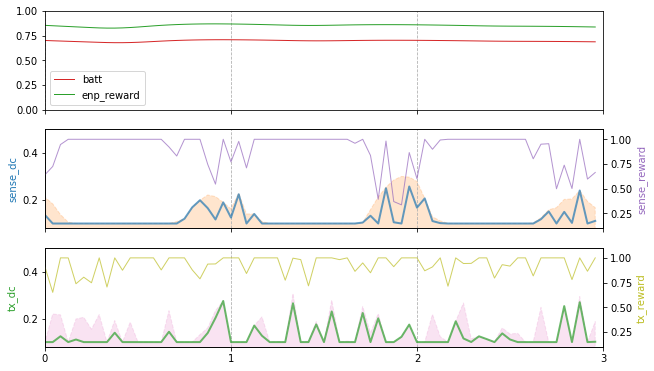

In [64]:
task3_plot(iteration_result, timeslots_per_day)